____

**project**: `Snake Spiece Identification (SSI)`

**date**: `2022-12-07`

**decription**: `given an image of a a snake we are gong to predict which specie does the snake belongs to among the available species in the train space`.

**main**: `computer vision(cv) pytorch`

**programmer**: `crispengari`

**architecture**:  `VGG_13`

**language**: `python`
____


### SSI Model

In this notebook I will train a computer vision model using deep learning technologies to classify different species of snakes. We are only going to look at `5` different speices of snakes based on the [aicrowd](https://www.aicrowd.com/challenges/snakeclef2021-snake-species-identification-challenge#datasets) challange.

![alt](https://storage.googleapis.com/kaggle-datasets-images/578272/1046298/b5b1741abdae8c8977cbbcfe6468527f/dataset-thumbnail.jpg?t=2020-05-18-11-39-04)

### Problem Statement
"Snakes have been a serious threat to human beings, but not all snakes are vernomus or bite to kill. People have been curious to know what type or class the snakes they see in their comunity belongs to."

In this project i will build a snakes classifier model that will be able to classify the name and specie of a snake. Given an image of a snake the model should accurately classify what speice does that snake belong to.


### Data
In this notebook I will train a simple snake classifier model using the dataset that was obtained from [kaggle](https://www.kaggle.com/datasets/sameeharahman/preprocessed-snake-images).

### Model Architecture
In this notebook I will create a image clasifier model that will classify `5` diffent spiecies of snakes. So basically this is a multi-class classification problem and i will use the `VGG_13` achitecture.


### Snake Species
The following are the different 5 snakes species that we are going to classify:

Class 1:
* `Nerodia sipedon` - Northern Watersnake

Class 2:
* `Thamnophis sirtalis` - Common Garter snake

Class 3:
* `Storeria dekayi` - DeKay's Brown snake

Class 4:
* `Patherophis obsoletus` - Black Rat snake

Class 5:
* `Crotalus atrox` - Western Diamondback rattlesnake


### Installing Helper Packages
In the following code cell we are going to install the package called `helperfns` that provide us with some usefull helper functions for machine learning.


In [1]:
pip install helperfns -q

  Preparing metadata (setup.py) ... done


### Imports
In the following code cell we are going to import all the packages that we are going to use throughout this notebook.

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torchvision

import random, time, os, copy, shutil
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

from sklearn import decomposition, manifold
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.torch import models
from helperfns.utils import hms_string


torch.__version__

'2.0.1+cu118'

### Seed
In the following code cell we are going to set-up the `SEED` for reproducivity in this notebook.

In [3]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get the `gpu` as our device if possible for training speed.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

As I mentioned the dataset that we are going to use is from `kaggle` we need a way of downloading and extracting it from `kaggle`. I will follow the steps that I listed on one of my previous notebooks [05_ResNet.ipynb](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/05_ResNet.ipynb).

In [5]:
!pip install kaggle -q

In [6]:
os.environ["KAGGLE_USERNAME"]="YOUR_USERNAME"
os.environ['KAGGLE_KEY'] = "YOUR_API_KEY"

In [7]:
!kaggle datasets download sameeharahman/preprocessed-snake-images --unzip

 99% 1.10G/1.11G [00:12<00:00, 149MB/s]
100% 1.11G/1.11G [00:12<00:00, 98.1MB/s]


To handle our dataset we are going to use the torch-vision class called `dataset.ImageFolder` and it expect the folder structure looks as follows:

```
root
  - classx
    - x.png
    - x.jpg
  ....

  - classy
    - y.png
    - y.jpg
```
This is exactly how our images are grouped in the `preprocessed-cleaned-set` folder. Our dataset only have one set which is the `train` we want to somewhere somehow come with the `test` set with all these classes. So in the following code cell we are going to move `20%` of image from the train set for each class and to the test set.

In [8]:
TRAIN_RATIO = 0.8

data_dir = 'preprocessed-cleaned-set'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

if not os.path.exists(test_dir):
  os.makedirs(test_dir)

print("copying files...")
for _class in os.listdir(train_dir):
  class_dir = os.path.join(train_dir, _class)
  images = os.listdir(class_dir)
  n_train = int(len(images) * TRAIN_RATIO)
  test_images = images[n_train:]
  os.makedirs(os.path.join(test_dir, _class), exist_ok = True)
  for image in test_images:
    image_src = os.path.join(class_dir, image)
    image_dst = os.path.join(test_dir, _class, image)
    shutil.copyfile(image_src, image_dst)

print("Done!")

copying files...
Done!


### Image Transformations

We are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb) page.

In [9]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
  transforms.Resize(pretrained_size),
  transforms.RandomRotation(5),
  transforms.RandomHorizontalFlip(0.5),
  transforms.RandomCrop(pretrained_size, padding = 10),
  transforms.ToTensor(),
  transforms.Normalize(mean = pretrained_means,
                      std = pretrained_stds)
])

test_transforms = transforms.Compose([
  transforms.Resize(pretrained_size),
  transforms.CenterCrop(pretrained_size),
  transforms.ToTensor(),
  transforms.Normalize(mean = pretrained_means,
                    std = pretrained_stds)
])

### Loading our custom Data

In the following code cell we are then going to load our custom data using the `ImageFolder` class from `torchvision`.

In [10]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transforms)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transforms)

Now we can create a validation data from the train set.

In [11]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])


Overiding the transforms of the train on the validation set with the test transforms.

In [12]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

### Checking examples
In the following code cell we are going to count how many examples we are having from our dataset.

In [13]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = [("training", len(train_data)),
             ("testing", len(test_data)),
             ("validation", len(valid_data)),
             ("total", f"{len(valid_data) + len(test_data) + len(train_data):,}")
        ]

tabulate_data(columns, data_rows, title)


DATASETS EXAMPLES
+------------+--------+
| SET        |  TOTAL |
+------------+--------+
| training   |  15650 |
| testing    |   3481 |
| validation |   1739 |
| total      | 20,870 |
+------------+--------+


### Iterator
In the following code cell we are then going to create an `iterator` with the batchsize of `64`

In [14]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size= BATCH_SIZE
)

valid_iterator = data.DataLoader(
    valid_data, batch_size= BATCH_SIZE
)

test_iterator = data.DataLoader(
    test_data,  batch_size= BATCH_SIZE
)

### Visualizing Images
Now we can go ahead and visualize the images that we are having in this dataset.

In [15]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

In the following code cell we are going to define the snake classes lists for later usage.

In [16]:
snakes_classes =[
    {
        "id": 0,
        "class": "class-1",
        "specie": "Nerodia sipedon",
        "name": "Northern Watersnake"
    },
     {
        "id": 1,
        "class": "class-2",
        "specie": "Thamnophis sirtalis",
        "name":"Common Garter snake"
    },
     {
        "id": 2,
        "class": "class-3",
        "specie": "Storeria dekayi",
        "name":"DeKay's Brown snake"
    },
     {
        "id": 3,
        "class": "class-4",
        "specie": "Patherophis obsoletus",
        "name":"Black Rat snake"
    },
     {
        "id": 4,
        "class": "class-5",
        "specie": "Crotalus atrox",
        "name":"Western Diamondback rattlesnake"
    },
]

In the following code cell we are going to define a function that will plot the normalised images from our datasets.

In [17]:
def plot_images(images, labels, classes, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(snakes_classes[labels[i]]["specie"], fontsize=10)
    ax.axis('off')

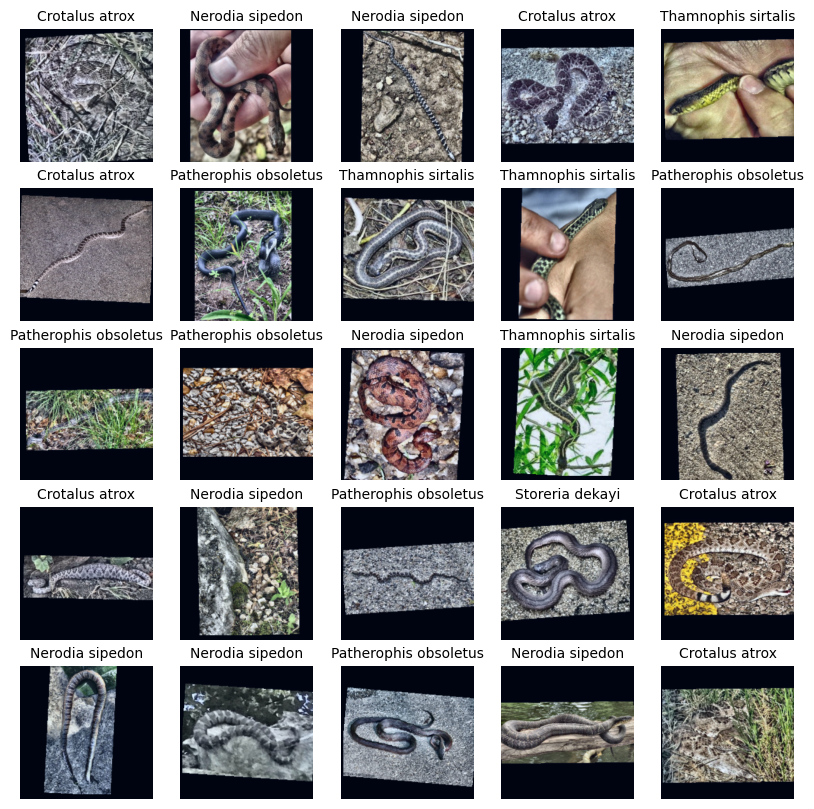

In [18]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

### Defining Model
As i said I will use the `VGG_13` model based on [this notebook](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/04_VGG.ipynb)
 we are going to define our model achitecture in the code cells that follows.

 Let's start by defining the `VGG` architecture in the following code cell:



In [19]:
class VGG(nn.Module):
  def __init__(self, features, output_dim):
    super().__init__()
    self.features = features
    self.avgpool = nn.AdaptiveAvgPool2d(7)

    self.classifier = nn.Sequential(
      nn.Linear(512 * 7 * 7, 4096),
      nn.ReLU(inplace = True),
      nn.Dropout(0.5),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace = True),
      nn.Dropout(0.5),
      nn.Linear(4096, output_dim)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

### `VGG_13` configuration
The `"B"` configuration which is also known as the `vgg13_config` is typically the VGG configurations are defined as lists. Each item in the list is either 'M', which denotes a max pooling layer, or an integer, which denotes a convolutional layer with that many filters.

In the following code cell we are going to define the `B` config.

In [20]:
B = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

We can now define a function which takes in a configuration list and returns a `nn.Sequential` with the respective layers.

In [21]:
def get_vgg_layers(config, batch_norm):
  layers = []
  in_channels = 3
  for c in config:
    assert c == 'M' or isinstance(c, int)
    if c == 'M':
      layers += [nn.MaxPool2d(kernel_size = 2)]
    else:
      conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
      if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
      else:
          layers += [conv2d, nn.ReLU(inplace = True)]
      in_channels = c
  return nn.Sequential(*layers)

Now, let's get the features for the VGG13 architecture, with batch normalization.

In [22]:
vgg13_layers = get_vgg_layers(B, batch_norm = True)
print(vgg13_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

We can then pass these features to our base VGG module to get our `VGG13` model.

In [23]:
OUTPUT_DIM = len(snakes_classes)
model = VGG(vgg13_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Counting model Parameters
In the following code cell we are going to count the `model` parameters of our model.

In [24]:
models.model_params(model)

TOTAL MODEL PARAMETERS: 	128,977,221
TOTAL TRAINABLE PARAMETERS: 	128,977,221


### Pretrained Models.

In this notebook I'm  actually going to use a VGG model with parameters that have been randomly initialized VGG model. I'm going to be using a VGG model with pre-trained parameters. Using a pre-trained model involves initializing our model with parameters that have already been trained for a certain task - usually not the exact same task we are trying to do ourselves.

In [25]:
pretrained_model = torchvision.models.vgg13_bn(pretrained = True)
print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth
100%|██████████| 508M/508M [00:03<00:00, 156MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Counting Pretrained Model Parameters


In [27]:
models.model_params(pretrained_model)

TOTAL MODEL PARAMETERS: 	133,053,736
TOTAL TRAINABLE PARAMETERS: 	133,053,736


### Fine Tuning
Our pretrained `VGG_13` model has `1000` output features of which we only have `5` classed in our dataset. We want to modify the last layer of our pretrained model so that it will have the output size based on our classes which is `5`

In [28]:
IN_FEATURES = pretrained_model.classifier[-1].in_features
final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
final_fc

Linear(in_features=4096, out_features=5, bias=True)

We can directly overwrite the previous linear layer with our new linear layer.

In [29]:
pretrained_model.classifier[-1] = final_fc

We can then print out the classifier of our model to ensure the final linear layer now has an output dimension of `5`.

In [30]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)


We could go ahead and use the `pretrained_model` module from here on out, however it only returns the final output layer and not the intermediate representation as our model does. We can see that in the model's definition here.

We can load the parameters of the pretrained_model into our model by loading the parameters `(state_dict)` from the `pretrained_model` into our model in the same way we loaded the "best" saved parameters in the previous notebooks - by using `load_state_dict`. However, this time we load directly from the `pretrained_model` instead of using `torch.load` on the path of the saved model parameters.

This is only possible as our model has the exact same layers (order and shape) as the `pretrained_model` with the final linear layer replaced with our `5` dimensional output linear layer.

In [31]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In the following code cell we are going to freeze the parameters of our fine tuned model except the last layer.

In [32]:
for parameter in model.features.parameters():
    parameter.requires_grad = False

for parameter in model.classifier[:-1].parameters():
    parameter.requires_grad = False


In [33]:
models.model_params(model)

TOTAL MODEL PARAMETERS: 	128,977,221
TOTAL TRAINABLE PARAMETERS: 	20,485


### Model Training
In the following code cell we are going to create create `optimizer` and `criterion`and put the model and optimizer to the `device`. Note that for the optimizer we are going to use the `Adam` with default parameters and `CrossEntropyLoss` as our loss function since it is a multi-class classification.

In [34]:
criterion = nn.CrossEntropyLoss().to(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

### Categorical Accuracy Function.
In the following code cell we are going to define our categorical loss function.

In [35]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Train and Evaluation Function
In the following code cell we are going to define our `train` and evaluation functions.

In [36]:

def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

###Training loop
We are then going to run our training loop as save the model when the previous validation loss is less that the current validation loss. We are only going to train the model for `10` epochs.

In [37]:
EPOCHS = 10
best_valid_loss = float('inf')
MODEL_NAME = "snakes-species.pt"
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  save_status = "(not saving)"
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    save_status = "(saving)"
    torch.save(model.state_dict(), MODEL_NAME)
  end = time.time()

  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]

  title = f"EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
  tabulate_data(column_names, data_rows, title)

EPOCH 01/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.818 |   68.35% | 0:03:23.85 |
| Validation | 0.610 |   77.43% |            |
+------------+-------+----------+------------+
EPOCH 02/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.717 |   72.99% | 0:03:30.41 |
| Validation | 0.559 |   79.49% |            |
+------------+-------+----------+------------+
EPOCH 03/10: (not saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.708 |   72.98% | 0:03:13.73 |
| Validation | 0.572 |   79.16% |            |
+------------+-------+----------+------------+
EPOCH 04/10: (saving)
+------------+-------+----------+------------+
| Set        | 

### Model Evaluation

In [38]:
model.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.491 |   81.51% |            |
+------+-------+----------+------------+


### Downloading the best model
We are going to download the saved model as a file in the following code cell.

In [39]:
from google.colab import files
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model Inference
For model inference we are going to take in an image and make predictions on it.

### Image preprocessing
For image preprocessing we are going to use `torchvision` transforms so we are basically going to use the `test_transforms` which looks as follows:

```py
test_transforms = transforms.Compose([
  transforms.Resize(pretrained_size),
  transforms.CenterCrop(pretrained_size),
  transforms.ToTensor(),
  transforms.Normalize(mean = pretrained_means,
                    std = pretrained_stds)
])
```

In [40]:
from PIL import Image

In [41]:
def preprocess_img(img):
  """
  takes in a pillow image and pre process it
  """
  img = test_transforms(img)
  return img

In [43]:
img_path = os.path.join('preprocessed-cleaned-set', "test/class-2/000089388ad956f0c33694e569d90fa9.jpg")
pil_img = Image.open(img_path)
img = preprocess_img(pil_img)

### Predict method
The predict method will take in the following args:

1. model
2. image (processed image)
3. device (cuda or cpu)

In [44]:
snakes_classes =[
    {
        "id": 0,
        "class_": "class-1",
        "specie_name": "Nerodia sipedon",
        "common_name": "Northern Watersnake"
    },
     {
        "id": 1,
        "class_": "class-2",
        "specie_name": "Thamnophis sirtalis",
        "common_name":"Common Garter snake"
    },
     {
        "id": 2,
        "class_": "class-3",
        "specie_name": "Storeria dekayi",
        "common_name":"DeKay's Brown snake"
    },
     {
        "id": 3,
        "class_": "class-4",
        "specie_name": "Patherophis obsoletus",
        "common_name":"Black Rat snake"
    },
     {
        "id": 4,
        "class_": "class-5",
        "specie_name": "Crotalus atrox",
        "common_name":"Western Diamondback rattlesnake"
    },
]

In [45]:
class Specie:
    def __init__(self, id: int, class_:str, specie_name: str, common_name: str) -> None:
        self.id = id
        self.class_ = class_
        self.common_name = common_name
        self.specie_name = specie_name

    def __repr__(self) -> str:
        return f"<{self.specie_name}>"

    def __str__(self) -> str:
        return f"<{self.specie_name}>"

    def to_json(self):
        return {
            "id": self.id,
            "class_": self.class_,
            "common_name": self.common_name,
            "specie_name": self.specie_name,
        }

class Prediction:
    def __init__(self, label:int, probability:float, class_name: str, specie: Specie) -> None:
        self.label = label
        self.probability = probability
        self.class_name = class_name
        self.specie = specie

    def __repr__(self) -> str:
        return f"<{self.class_name}>"

    def __str__(self) -> str:
        return f"<{self.class_name}>"

    def to_json(self):
        return {
            "label": int(self.label),
            "probability": float(self.probability),
            "class_name": self.class_name,
            "specie": self.specie.to_json()
        }

class Response:
    def __init__(self, top_prediction: Prediction, predictions:list) -> None:
        self.predictions = predictions
        self.top_prediction = top_prediction

    def __repr__(self) -> str:
        return f"<SSI Prediction Response>"

    def __str__(self) -> str:
        return f"<SSI Prediction Response>"

    def to_json(self):
        return{
           "predictions": [item.to_json() for item in self.predictions],
            "top_prediction": self.top_prediction.to_json()
        }


In [46]:
def predict(model, image, device):
    image = image.unsqueeze(dim=0).to(device)
    preds, _ = model(image)
    preds = F.softmax(preds, dim=1).detach().cpu().numpy().squeeze()
    predicted_label = np.argmax(preds)
    predictions = [
        Prediction(
            label= i,
            class_name = classes[i],
            probability = np.round(preds[i], 2),
            specie = Specie(
                id = snakes_classes[i]['id'],
                class_ = snakes_classes[i]['class_'],
                common_name = snakes_classes[i]['common_name'],
                specie_name = snakes_classes[i]['specie_name']
            )
        ) for i, _ in enumerate(preds)
    ]
    predicted = Prediction(
        label= predicted_label,
        class_name = classes[predicted_label],
        probability = np.round(preds[predicted_label], 2),
        specie = Specie(
            id = snakes_classes[predicted_label]['id'],
            class_ = snakes_classes[predicted_label]['class_'],
            common_name = snakes_classes[predicted_label]['common_name'],
            specie_name = snakes_classes[predicted_label]['specie_name'],

        )
    )
    return Response(
        top_prediction = predicted,
        predictions = predictions
    )
predict(model, img, device).to_json()

{'predictions': [{'label': 0,
   'probability': 0.009999999776482582,
   'class_name': 'class-1',
   'specie': {'id': 0,
    'class_': 'class-1',
    'common_name': 'Northern Watersnake',
    'specie_name': 'Nerodia sipedon'}},
  {'label': 1,
   'probability': 0.9700000286102295,
   'class_name': 'class-2',
   'specie': {'id': 1,
    'class_': 'class-2',
    'common_name': 'Common Garter snake',
    'specie_name': 'Thamnophis sirtalis'}},
  {'label': 2,
   'probability': 0.0,
   'class_name': 'class-3',
   'specie': {'id': 2,
    'class_': 'class-3',
    'common_name': "DeKay's Brown snake",
    'specie_name': 'Storeria dekayi'}},
  {'label': 3,
   'probability': 0.019999999552965164,
   'class_name': 'class-4',
   'specie': {'id': 3,
    'class_': 'class-4',
    'common_name': 'Black Rat snake',
    'specie_name': 'Patherophis obsoletus'}},
  {'label': 4,
   'probability': 0.0,
   'class_name': 'class-5',
   'specie': {'id': 4,
    'class_': 'class-5',
    'common_name': 'Western Diam

### Refs

1. [aicrowd](https://www.aicrowd.com/challenges/snakeclef2021-snake-species-identification-challenge/notebooks)